In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_theme(rc = {'figure.figsize':(9,6)})
print(sns.__version__)

0.13.2


In [3]:
events_data = pd.read_csv('event_data_train.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'event_data_train.csv'

In [ ]:
events_data.head(10)

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632
5,32811,1434340895,passed,17632
6,32929,1434340921,discovered,17632
7,32929,1434340921,viewed,17632
8,32929,1434340939,started_attempt,17632
9,32929,1434340944,passed,17632


In [4]:
events_data.action.unique()
events_data['date'] = pd.to_datetime(events_data.timestamp, unit = 's')
events_data.head()

NameError: name 'events_data' is not defined

In [5]:
print(events_data.date.min(), events_data.date.max())
events_data['day'] = events_data.date.dt.date
display(events_data.head())
events_data.groupby('day').user_id.nunique().plot()

NameError: name 'events_data' is not defined

<Axes: >

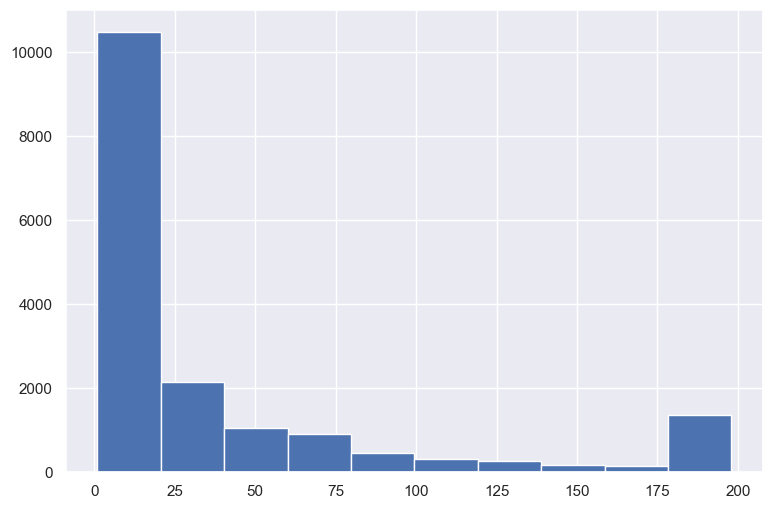

In [7]:
events_data[events_data.action == 'passed']\
.groupby('user_id', as_index = False)\
.agg({'step_id': 'count'})\
.rename(columns = {'step_id': 'passed_steps'}).passed_steps.hist()

In [8]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [9]:
user_events = events_data.pivot_table(index = 'user_id',
                        columns = 'action',
                        values = 'step_id', 
                        aggfunc = 'count', 
                        fill_value = 0).reset_index()

<Axes: >

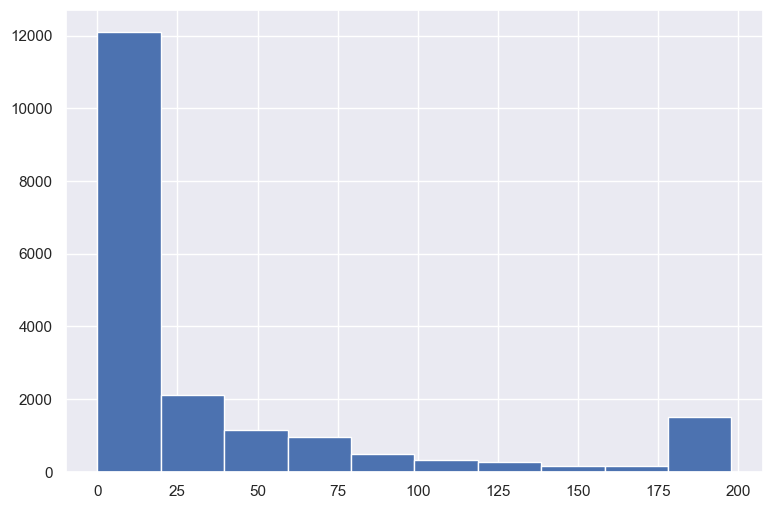

In [10]:
events_data.pivot_table(index = 'user_id',
                        columns = 'action',
                        values = 'step_id', 
                        aggfunc = 'count',  
                        fill_value = 0).reset_index().discovered.hist()

In [11]:
submissions_data = pd.read_csv('submissions_data_train.csv')
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit = 's')
submissions_data['day'] = submissions_data.date.dt.date

display(submissions_data.head())

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [12]:
user_scores = submissions_data.pivot_table(index = 'user_id',
            columns = 'submission_status',
            values = 'step_id', 
            aggfunc = 'count',  
            fill_value = 0).reset_index()
user_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


np.float64(59.760440972222156)

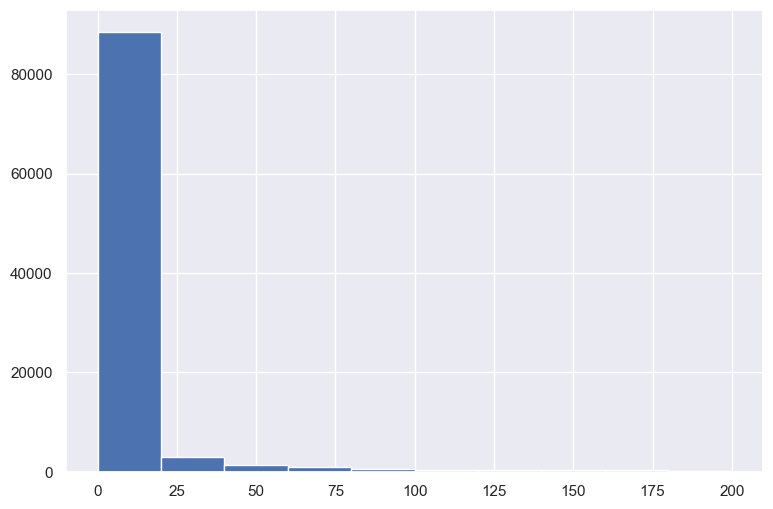

In [13]:
gap_data = events_data[['user_id','day', 'timestamp']].drop_duplicates(subset = ['user_id', 'day'])\
.groupby('user_id')['timestamp'].apply(list)\
.apply(np.diff).values

gap_data = pd.Series(np.concatenate(gap_data, axis = 0))
gap_data = gap_data / (24 * 60 * 60) #diff in days
gap_data[gap_data < 200].hist()

gap_data.quantile(0.95) #95 th percentile, on;y 5 percent return after 59 days

In [14]:
events_data.tail()

,step_id,timestamp,action,user_id,date,day
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19
3480702,33892,1526772811,viewed,18526,2018-05-19 23:33:31,2018-05-19


In [15]:
users_data = events_data.groupby('user_id', as_index = False)\
    .agg({'timestamp':'max'}).rename(columns = {'timestamp':'lastTimestamp'})
now = 1526772811
dropOutTresh = 30 * 24 * 60 * 60
users_data['is_gone_user'] = (now - users_data.lastTimestamp) > dropOutTresh
users_data

,user_id,lastTimestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True
...,...,...,...
19229,26790,1517495987,True
19230,26793,1510225034,True
19231,26794,1512035039,True
19232,26797,1509995096,True


In [16]:
user_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [17]:
users_data.head()

,user_id,lastTimestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


In [18]:
users_data = users_data.merge(user_scores, on = 'user_id', how = 'outer') #can add on = 'user_id'
users_data = users_data.fillna(0)

In [19]:
users_data.head()

,user_id,lastTimestamp,is_gone_user,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0


In [20]:
users_data = users_data.merge(user_events, how = 'outer')
users_data.head()

,user_id,lastTimestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,0.0,0.0,1,1,0,1


In [21]:
users_data.passed

0         0
1         9
2        87
3        11
4         1
         ..
19229     8
19230     0
19231    69
19232    10
19233    12
Name: passed, Length: 19234, dtype: int64

In [22]:
user_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()
users_data = users_data.merge(user_days, how = 'outer')
users_data.head()

,user_id,lastTimestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1


In [23]:
users_data['passed_course'] = users_data.passed > 170

In [24]:
users_data.groupby('passed_course').count()

,user_id,lastTimestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
passed_course,,,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425


In [25]:
1425 / 17809 * 100

8.001572238755687

$\Huge \text{Decision Trees}$

In [26]:
from sklearn import tree
import pandas as pd
import seaborn as sns

In [27]:
data = pd.DataFrame({'X_1': [1, 1, 1, 0, 0, 0, 0, 1], 'X_2': [0, 0, 0, 1, 0, 0, 0, 1], 'Y': [1, 1, 1, 1, 0, 0, 0, 0]})
data

,X_1,X_2,Y
0,1,0,1
1,1,0,1
2,1,0,1
3,0,1,1
4,0,0,0
5,0,0,0
6,0,0,0
7,1,1,0


In [28]:
clf = tree.DecisionTreeClassifier(criterion = 'entropy')
X = data[['X_1', 'X_2']]
y = data.Y
clf.fit(X,y)

DecisionTreeClassifier(criterion='entropy')

In [29]:
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from IPython.display import HTML
style = "<style>svg{width:70% !important;height:70% !important;}</style>"
HTML(style)

In [30]:
import graphviz
graphviz.version()

(12, 2, 1)

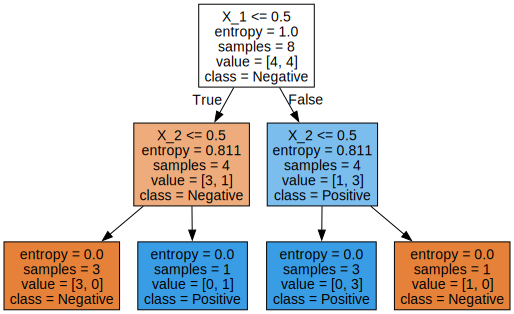

In [31]:
graph = Source(tree.export_graphviz(clf,out_file = None,
                                    feature_names=list(X),
                                    class_names = ['Negative','Positive'],
                                    filled = True))
display(SVG(graph.pipe(format='svg')))

$\huge \text{Отток студентов со Stepik}$

In [32]:
users_data.head()

,user_id,lastTimestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


<Axes: >

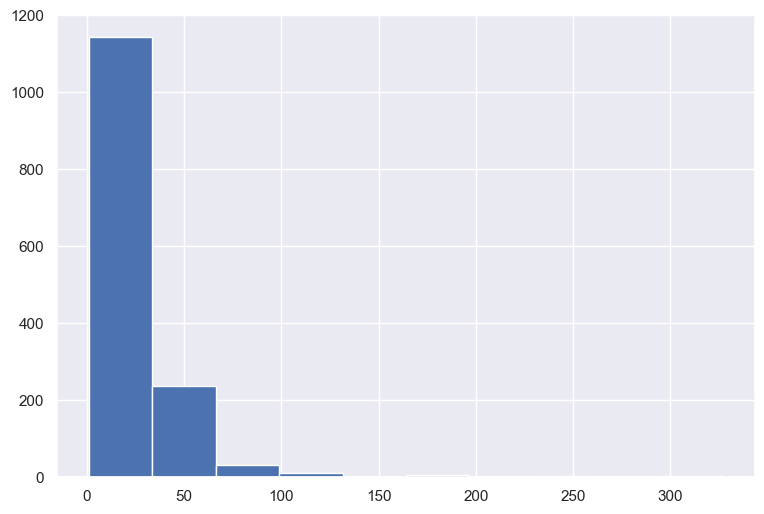

In [33]:
users_data[users_data.passed_course].day.hist()

In [34]:
user_min_time = events_data.groupby('user_id', as_index=False)\
                    .agg({'timestamp':'min'})\
                    .rename({'timestamp':'min_timestamp'}, axis = 1)
user_min_time.head()

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


In [35]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [36]:
events_data['user_time'] = events_data.user_id.map(str) + '_' + events_data.timestamp.map(str)
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895


In [37]:
learning_time_threshold = 3 * 24 * 60 * 60
user_learning_time_threshold = user_min_time.user_id.map(str) + '_' + (user_min_time.min_timestamp + learning_time_threshold).map(str)
user_learning_time_threshold.head()

0    1_1473086664
1    2_1514642564
2    3_1434617676
3    5_1466416009
4    7_1521893860
dtype: object

In [38]:
user_min_time['user_learning_time_threshold'] = user_learning_time_threshold
user_min_time.head()


,user_id,min_timestamp,user_learning_time_threshold
0,1,1472827464,1_1473086664
1,2,1514383364,2_1514642564
2,3,1434358476,3_1434617676
3,5,1466156809,5_1466416009
4,7,1521634660,7_1521893860


In [45]:
events_data = events_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,31981,1472827464,viewed,1,2016-09-02 14:44:24,2016-09-02,1_1472827464,1_1473086664
1,31981,1472827464,discovered,1,2016-09-02 14:44:24,2016-09-02,1_1472827464,1_1473086664
2,32815,1514383364,discovered,2,2017-12-27 14:02:44,2017-12-27,2_1514383364,2_1514642564
3,32815,1514383364,viewed,2,2017-12-27 14:02:44,2017-12-27,2_1514383364,2_1514642564
4,32815,1514383364,passed,2,2017-12-27 14:02:44,2017-12-27,2_1514383364,2_1514642564


In [40]:
events_data.shape

(3480703, 8)

In [46]:
events_data_train = events_data[events_data.user_time <= events_data.user_learning_time_threshold]
events_data_train.sort_values(by='user_id', ascending=False)

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
3480702,31955,1520978742,viewed,26798,2018-03-13 22:05:42,2018-03-13,26798_1520978742,26798_1521234963
3480683,32816,1520978074,discovered,26798,2018-03-13 21:54:34,2018-03-13,26798_1520978074,26798_1521234963
3480681,32812,1520978070,passed,26798,2018-03-13 21:54:30,2018-03-13,26798_1520978070,26798_1521234963
3480680,32812,1520978066,started_attempt,26798,2018-03-13 21:54:26,2018-03-13,26798_1520978066,26798_1521234963
3480679,32812,1520978036,started_attempt,26798,2018-03-13 21:53:56,2018-03-13,26798_1520978036,26798_1521234963
...,...,...,...,...,...,...,...,...
29,32927,1514383555,discovered,2,2017-12-27 14:05:55,2017-12-27,2_1514383555,2_1514642564
30,32927,1514383555,passed,2,2017-12-27 14:05:55,2017-12-27,2_1514383555,2_1514642564
3,32815,1514383364,viewed,2,2017-12-27 14:02:44,2017-12-27,2_1514383364,2_1514642564
1,31981,1472827464,discovered,1,2016-09-02 14:44:24,2016-09-02,1_1472827464,1_1473086664


In [49]:
events_data_train.groupby('user_id').day.nunique().max()

np.int64(4)

In [99]:
submissions_data['users_time'] = submissions_data.user_id.map(str) + '_' + submissions_data.timestamp.map(str)
submissions_data = submissions_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')
submissions_data_train = submissions_data[submissions_data.users_time <= submissions_data.user_learning_time_threshold]
submissions_data_train.groupby('user_id').day.nunique().max()

submissions_data_train.head()

,step_id,timestamp,submission_status,user_id,date,day,users_time,user_learning_time_threshold
1,32812.0,1.514383e+09,correct,2,2017-12-27 14:04:45,2017-12-27,2_1514383485.0,2_1514642564
2,32929.0,1.514383e+09,correct,2,2017-12-27 14:03:40,2017-12-27,2_1514383420.0,2_1514642564
6,31977.0,1.434359e+09,wrong,3,2015-06-15 09:10:32,2015-06-15,3_1434359432.0,3_1434617676
7,31977.0,1.434360e+09,wrong,3,2015-06-15 09:12:00,2015-06-15,3_1434359520.0,3_1434617676
8,31977.0,1.434360e+09,wrong,3,2015-06-15 09:12:21,2015-06-15,3_1434359541.0,3_1434617676


$\huge \text{Обучение}$

In [169]:
X = submissions_data_train.groupby('user_id').day.nunique().to_frame().reset_index()
X.head()

,user_id,day
0,2,1
1,3,1
2,8,1
3,14,1
4,16,3


In [170]:
steps_tried = submissions_data_train.groupby('user_id').step_id.nunique().to_frame().reset_index()\
.rename(columns = {'step_id': 'steps_tried'})
steps_tried.head()

,user_id,steps_tried
0,2,2
1,3,4
2,8,11
3,14,1
4,16,23


In [171]:
X = X.merge(steps_tried, on='user_id', how='outer').rename(columns = {'day':'days'})
X.shape

(8913, 3)

In [172]:
X.head()

,user_id,days,steps_tried
0,2,1,2
1,3,1,4
2,8,1,11
3,14,1,1
4,16,3,23


In [173]:
submissions_data_train

,step_id,timestamp,submission_status,user_id,date,day,users_time,user_learning_time_threshold
1,32812.0,1.514383e+09,correct,2,2017-12-27 14:04:45,2017-12-27,2_1514383485.0,2_1514642564
2,32929.0,1.514383e+09,correct,2,2017-12-27 14:03:40,2017-12-27,2_1514383420.0,2_1514642564
6,31977.0,1.434359e+09,wrong,3,2015-06-15 09:10:32,2015-06-15,3_1434359432.0,3_1434617676
7,31977.0,1.434360e+09,wrong,3,2015-06-15 09:12:00,2015-06-15,3_1434359520.0,3_1434617676
8,31977.0,1.434360e+09,wrong,3,2015-06-15 09:12:21,2015-06-15,3_1434359541.0,3_1434617676
...,...,...,...,...,...,...,...,...
518393,32812.0,1.508426e+09,correct,26797,2017-10-19 15:10:28,2017-10-19,26797_1508425828.0,26797_1508684516
518394,32929.0,1.508425e+09,correct,26797,2017-10-19 15:02:47,2017-10-19,26797_1508425367.0,26797_1508684516
518395,32812.0,1.520978e+09,wrong,26798,2018-03-13 21:54:23,2018-03-13,26798_1520978063.0,26798_1521234963
518396,32812.0,1.520978e+09,correct,26798,2018-03-13 21:54:30,2018-03-13,26798_1520978070.0,26798_1521234963


In [174]:
X = X.merge(submissions_data_train.pivot_table(index = 'user_id',
            columns = 'submission_status',
            values = 'step_id', 
            aggfunc = 'count',  
            fill_value = 0).reset_index())
X['correct_ratio'] = X.correct / (X.correct + X.wrong)
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio
0,2,1,2,2,0,1.00
1,3,1,4,4,4,0.50
2,8,1,11,9,21,0.30
3,14,1,1,0,1,0.00
4,16,3,23,23,27,0.46


In [175]:
X = X.merge(events_data_train.pivot_table(index = 'user_id',
            columns = 'action',
            values = 'step_id', 
            aggfunc = 'count',  
            fill_value = 0).reset_index()[['user_id', 'viewed']], how = 'outer')

In [176]:
X = X.fillna(0)

In [177]:
X = X.merge(users_data[['user_id','passed_course', 'is_gone_user']], how='outer')
X = X[~((X.is_gone_user == False) & (X.passed_course == False))] #~ - значок отрицания

In [178]:
X.groupby(['passed_course', 'is_gone_user']).user_id.count()

passed_course  is_gone_user
False          True            16560
True           False             141
               True             1284
Name: user_id, dtype: int64

In [179]:
y = X.passed_course
X = X.drop(['passed_course', 'is_gone_user'], axis = 1)
X = X.set_index(X.user_id)
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,,
1,1,0.0,0.0,0.0,0.0,0.0,1
2,2,1.0,2.0,2.0,0.0,1.0,9
3,3,1.0,4.0,4.0,4.0,0.5,20
5,5,0.0,0.0,0.0,0.0,0.0,1
7,7,0.0,0.0,0.0,0.0,0.0,1


In [180]:
X = X.drop('user_id', axis = 1)
X.head()

,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
1,0.0,0.0,0.0,0.0,0.0,1
2,1.0,2.0,2.0,0.0,1.0,9
3,1.0,4.0,4.0,4.0,0.5,20
5,0.0,0.0,0.0,0.0,0.0,1
7,0.0,0.0,0.0,0.0,0.0,1
